In [1]:
import torch
from torchvision import transforms

### Подготовка данных

In [2]:
from torchvision.datasets import MNIST

In [3]:
_tasks = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [4]:
## Load MNIST Dataset and apply transformations
mnist = MNIST('./MNIST_data', download=True, train=True, transform=_tasks)

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [6]:
## create training and validation split 
split = int(0.8 * len(mnist))
index_list = list(range(len(mnist)))
train_idx, valid_idx = index_list[:split], index_list[split:]

In [7]:
## create sampler objects using SubsetRandomSampler
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)

In [8]:
## create iterator objects for train and valid datasets
batch_size = 50
trainloader = DataLoader(mnist, batch_size=batch_size, sampler=tr_sampler)
validloader = DataLoader(mnist, batch_size=batch_size, sampler=val_sampler)

### Задаем архитектуру нейросети

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets

import numpy as np

%matplotlib inline

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Связь между параметрами свертки и шириной входного/выходного изображения:

$$W_{out} = \frac{(W_{in} - K + 2P)}{S} + 1$$

где $W_{int}$ - ширина входа, $K$ - размер ядра, $P$ - padding, $S$ - шаг

Источник: https://neurohive.io/ru/tutorial/cnn-na-pytorch/ 

In [11]:
class Net(nn.Module):
    def __init__(self, name='nn'): 
        super().__init__()
        self.name = name
        
        # сверточные слои
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) 
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) 
        
        self.drop_out = nn.Dropout() 
        
        # полносвязные слои
        self.fc1 = nn.Linear(7 * 7 * 32, 1000) 
        self.fc2 = nn.Linear(1000, 10)
        
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)
        
    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out) 
                
        out = out.reshape(out.size(0), -1) #out.view(-1, 32*7*7)
        out = self.drop_out(out) 
        
        out = self.fc1(out) 
        out = torch.tanh(out)
        out = self.fc2(out) 
        
        return out                
    
    def loss(self, output, target):                
        return F.cross_entropy(output, target) #объединяет и SoftMax и кросс-энтропийную функцию потерь

In [12]:
# аналогичная сеть, заточенная для визуализации происходящего на каждом слое
class NetPainter(nn.Module):
    def __init__(self, name='nn'): 
        super().__init__()
        self.name = name
        
        # сверточные слои
        self.layer1conv = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.layer2conv = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.drop_out = nn.Dropout() 
        
        # полносвязные слои
        self.fc1 = nn.Linear(7 * 7 * 32, 1000) 
        self.fc2 = nn.Linear(1000, 10)
        
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)
        
    def forward(self, x): 
        out = dict()
        
        # 1й сверточный слой
        y = self.layer1conv(x) 
        out['layer1conv'] = y
        y = self.relu1(y) 
        out['relu1'] = y
        y = self.pool1(y)
        out['pool1'] = y
        
        # 2й сверточный слой
        y = self.layer2conv(y) 
        out['layer2conv'] = y
        y = self.relu1(y) 
        out['relu2'] = y
        y = self.pool1(y)
        out['pool2'] = y
                
        y = y.reshape(y.size(0), -1) #out.view(-1, 32*7*7)
        out['flatten'] = y
        y = self.drop_out(y)
        out['dropout'] = y
        
        y = self.fc1(y) 
        out['dense1'] = y
        y = torch.tanh(y)
        out['denseTanh'] = y
        y = self.fc2(y) 
        out['y'] = y
        
        return out                
    
    def loss(self, output, target):                
        return F.cross_entropy(output, target) #объединяет и SoftMax и кросс-энтропийную функцию потерь

### Тренировка

######  несколько вспомогательных функций

In [13]:
# Возвращает число попаданий на проверочном наборе validloader
def get_accuracy(model, validloader):
    accuracys = np.array([])
  
    for images, targets in validloader:
        total = targets.size(0)                       
        
        with torch.no_grad():                        
            output = model(images)
            if isinstance(output, dict):
                output = output['y']
            _, pos = output.max(1)            
            correct = (pos == targets).sum().item()                            
            
            accuracys = np.append(accuracys, correct/total)
        
    accuracy = accuracys.mean()
    
    return accuracy

In [14]:
# Строит графики
def show(loss_history, metrics_history, title):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

    ax1.plot(loss_history['valid'], label='на проверочном наборе')
    ax1.plot(loss_history['train'], label='на обучающем наборе')
    ax1.grid()
    ax1.set_title(title)    
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(metrics_history['accuracy'], label='accuracy')
    ax2.grid()
    ax2.set_title(title) 
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Accuracy')
    ax2.legend();

In [15]:
# отрисовывает в черно-белом стиле изображения из массива images,
# расставляя их по матрице формы shape
def plot_mnist(images, shape, title):
    fig = plt.figure(figsize=shape[::-1], dpi=80)    
    
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    print(title, ': ')
    plt.show()

In [16]:
# Отрисовывает image - матрицу ч/б картинки
def plot_img(image, shape, title):
    fig, ax = plt.subplots(figsize=(shape[1],shape[0])) 
    ax.matshow(image, cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

    print(title)
    plt.show() 
    
# Отрисовывает серию изорбражений
# images - массив из матриц ч/б картинок
def plot_imgs(images, shape, title):    
    fig, ax = plt.subplots(figsize=(shape[1],shape[0]))
    
    for j in range(len(images)):                
        ax = fig.add_subplot(shape[0], shape[1], j+1)
        ax.matshow(images[j], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    print(title)
    plt.show() 
  
# Рисует плоский массив как график кривой
def plot_line(arr, shape, title):
    fig, ax = plt.subplots(figsize=(shape[1],shape[0]))
    
    x = np.linspace(0, arr.shape[0], arr.shape[0])
    ax.plot(x, arr)

    print(title)
    plt.show()

In [17]:
# тренирует с отслеживанием показателей
def train_eval(N_epoch, model):
    print('Model %s :' % model.name)
    
    loss_history = {'train': [], 'valid': []}
    metrics_history = {'accuracy':[]}
    
    for epoch in range(1, N_epoch): ## run the model for series of epochs
        train_loss, valid_loss = [], []
        n_batches = len(trainloader)

        ## training part 
        model.train()        
        for i, (images, targets) in enumerate(trainloader):
            model.optimizer.zero_grad()

            ## 1. прямой ход
            output = model(images)
            if isinstance(output,dict):
                output = output['y']

            ## 2. рассчет ошибки
            loss = model.loss(output, targets)

            ## 3. обратный ход
            loss.backward()

            ## 4. оптимизация весов
            model.optimizer.step()

            train_loss.append(loss.item())
            
            if (i + 1) % 200 == 0:
                print(f'Epoch: {epoch}, Batch: {i+1}/{n_batches}', end=',')
                print(f'Train Loss:{np.mean(train_loss)}')                      

        loss_history['train'].append(np.mean(train_loss))

        ## evaluation part 
        model.eval()
        for images, targets in validloader:
            output = model(images)
            if isinstance(output,dict):
                output = output['y']
            loss = model.loss(output, targets)
            valid_loss.append(loss.item())

        loss_history['valid'].append(np.mean(valid_loss))

        acc = get_accuracy(model, validloader)
        metrics_history['accuracy'].append(acc)

        print(f'Epoch: {epoch}', end=',')
        print(f'Valid Loss: {np.mean(valid_loss)}', end=',')
        print(f'Accuracy: {acc}')
            
    return (model, loss_history, metrics_history)

######  собственно обучение

In [18]:
# Запускаем обучение сети с акцентом на визуализацю внутренней кухни
modelsP =[NetPainter('nn_painter')]

In [18]:
historyP = []
for i, model in enumerate(modelsP):
    N_epochs = 10
      
    net, loss_history, metrics_history = train_eval(N_epochs,model)
    historyP.append({'net': net, 'loss': loss_history, 'metrics': metrics_history })

Model nn_painter :
Epoch: 1, Batch: 200/960,Train Loss:0.9336638826876879
Epoch: 1, Batch: 400/960,Train Loss:0.6465394562110305
Epoch: 1, Batch: 600/960,Train Loss:0.5138441018698117
Epoch: 1, Batch: 800/960,Train Loss:0.43897605714388194
Epoch: 1,Valid Loss: 0.11729571463850637,Accuracy: 0.9658333333333334
Epoch: 2, Batch: 200/960,Train Loss:0.16356235031038524
Epoch: 2, Batch: 400/960,Train Loss:0.15533819126896561
Epoch: 2, Batch: 600/960,Train Loss:0.14975248029455543
Epoch: 2, Batch: 800/960,Train Loss:0.14635515263536944
Epoch: 2,Valid Loss: 0.07706893783955214,Accuracy: 0.9780000000000001
Epoch: 3, Batch: 200/960,Train Loss:0.11836276124231518
Epoch: 3, Batch: 400/960,Train Loss:0.11515535959973931
Epoch: 3, Batch: 600/960,Train Loss:0.11323501008873184
Epoch: 3, Batch: 800/960,Train Loss:0.1124965192086529
Epoch: 3,Valid Loss: 0.0671429690439254,Accuracy: 0.9800833333333334
Epoch: 4, Batch: 200/960,Train Loss:0.09227821578271687
Epoch: 4, Batch: 400/960,Train Loss:0.0928412842

In [18]:
#сохранение состояния модели

#model4save = modelsP[0]
#torch.save(model4save.state_dict(), 'the_model_state_dict.pt')

#еще один способ сохранения модели
#torch.save(model4save, 'the_model.pt')

In [19]:
#загрузка сохраненного состояния модели

checkpoint = torch.load('the_model_state_dict.pt')
#checkpoint
modelsP[0].load_state_dict(checkpoint)
modelsP[0].eval()

NetPainter(
  (layer1conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop_out): Dropout(p=0.5)
  (fc1): Linear(in_features=1568, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

### Визуализируем результаты обучения

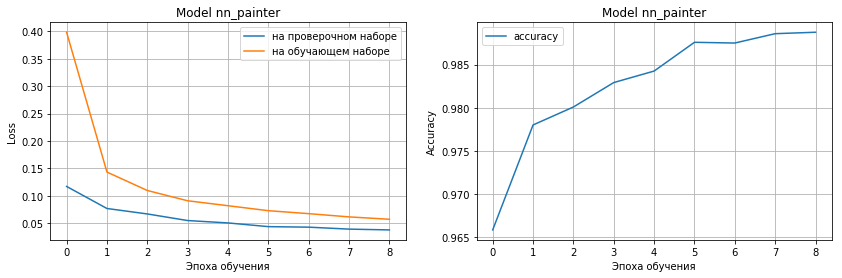

In [22]:
# Визуализируем показатели обучения
for way in historyP:
    show(way['loss'], way['metrics'], 'Model ' + way['net'].name) 

Батч из тестового набора : 


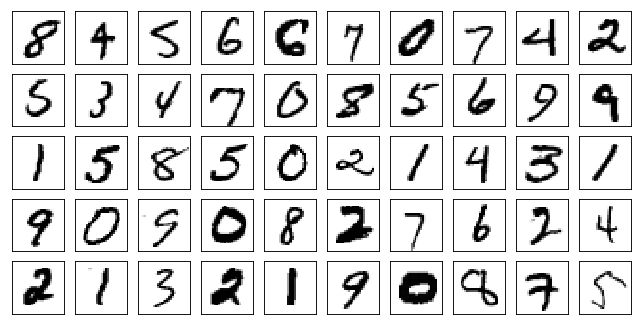

Что увидела нейросеть: 
 tensor([8, 4, 5, 6, 6, 7, 0, 7, 4, 2, 5, 3, 4, 7, 0, 8, 5, 6, 9, 9, 1, 5, 8, 5,
        0, 2, 1, 4, 3, 1, 9, 0, 9, 0, 8, 2, 7, 6, 2, 4, 2, 1, 3, 2, 1, 9, 0, 2,
        7, 5])
Правильных ответов 49 из 50


In [20]:
# Посмотрим результаты в виде вход-выход на примере одного из батчей
data, targets = next(iter(validloader))

plot_mnist(data.data.numpy(), (5, 10), 'Батч из тестового набора')

modelka = modelsP[0]
output = modelka(data)

_, pos = output['y'].max(1)
print(f'Что увидела нейросеть: \n {pos}')

correct = (pos == targets).sum().item()
total = targets.size(0)
print(f'Правильных ответов {correct} из {total}')

### Теперь - задача наоборот:
### Оптимизация изображения под активацию сверточных нейронов классификатора

Фиксируете веса сети и смещения, а затем "обучаете" модель так, чтобы получить максимальную активацию на заданном нейроне, соответсвующем, например, цифре 0, 1, 2... и так далее - любой, какую выберете. Если модель - это Wx + b, и веса - W, а данные - x, то при обучении на максимизацию активации нейрона вы фиксируете W и "обучаете" (оптимизируете) x и на выходе получаете "оптимальную" картинку под заданный нейрон с точки зрения весов. Вы как бы делаете backpropagation на пикселях, а обученные веса модели используете как входные данные

##### Будем работать с нейроном номер 7

Вспомогательные функции

In [30]:
from scipy.optimize import minimize

# визуализирует цифру
def show_im(imago, title="Картинка"):
    image = imago.data.numpy()[0][0]
    plot_img(image, (3,5), title)

# Возвращает значение функции активации neuron-го нейрона 1го полносвязного слоя (последнего с функцией активации)
# модели net.
# vector - развернутое в вектор изображение
def activationSingle(vector, net, neuron):    
    vector = torch.tensor(vector).float()
    imago = vector.view(1,1,28,28)    
    output = net(imago)   
    return -output['denseTanh'][0][neuron].item()

# Возвращает значение на выходе neuron-го нейрона 2го полносвязного слоя (выходной слой)
# модели net.
# vector - развернутое в вектор изображение
def activationSingleOut(vector, net, neuron):    
    vector = torch.tensor(vector).float()
    imago = vector.view(1,1,28,28)    
    output = net(imago)   
    return -output['y'][0][neuron].item()

In [ ]:
Возбмем входное изображение

In [22]:
data, targets = next(iter(validloader))
neuron = 6

Выходной слой (2й полносвязный):
 tensor([[-7.3579,  1.9114, -3.5297, -3.8737, 16.6877, -2.6665, -5.2886,  1.8478,
          2.2370,  2.9719]], grad_fn=<AddmmBackward>)
Нейросеть опознала цифру: 
 4
Картинка:


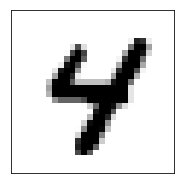

значение функции активации на 7м нейроне 1го полносвязного слоя: 0.48599323630332947


/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [29]:
imago = data.split(split_size=1, dim=0)[0]
output = modelka(imago)   

print('Выходной слой (2й полносвязный):\n', output['y'])
_, pos = output['y'].max(1) # выбираем класс с максимальным сигналом
print(f'Нейросеть опознала цифру: \n {pos.item()}')

show_im(imago)

vector0 = imago[0][0].view(28*28,1)

start_activation = activationSingle(vector0, modelka, neuron)
print(F"значение функции активации на 7м нейроне 1го полносвязного слоя: {start_activation}")

#####  Максимизируем фунцию активации 7го нейрона 1го полносвязного слоя

In [26]:
res = minimize(activationSingle, vector0, args=(modelka,6), method='BFGS', tol=1e-5)
print(f' fun={res.fun} \n nfev={res.nfev} \n nit={res.nit} \n success={res.success}')

 fun=0.48599323630332947 
 nfev=24366 
 nit=1 
 success=True


In [28]:
res1 = minimize(activationSingle, vector0, args=(modelka,6), method='Nelder-Mead', tol=1e-5)
print(f' fun={res1.fun} \n nfev={res1.nfev} \n nit={res1.nit} \n success={res1.success}')

 fun=-0.049513477832078934 
 nfev=156800 
 nit=153109 
 success=False


Nelder-Mead как-бы не достиг усперха, но в итоге сработал лучше BFGS (глубже минимум => выше максимум)

Визуализируем:

оптимизированное (BFGS) изображение


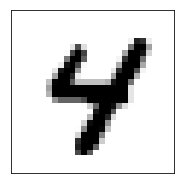

Значение функции активации на 7м нейроне -0.48599323630332947 

оптимизированное (Nelder-Mead) изображение


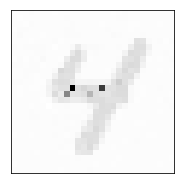

Значение функции активации на 7м нейроне 0.049513477832078934


In [35]:
# нарисуем изображение, оптимизированное по BFGS
vector = torch.tensor(res.x).float()
imago = vector.view(1,1,28,28)
show_im(imago, 'оптимизированное (BFGS) изображение')

print('Значение функции активации на 7м нейроне', modelka(imago)['denseTanh'][0][6].item(), '\n')

# нарисуем изображение, оптимизированное по Nelder-Mead
vector1 = torch.tensor(res1.x).float()
imago1 = vector1.view(1,1,28,28)
show_im(imago1, 'оптимизированное (Nelder-Mead) изображение')

print('Значение функции активации на 7м нейроне', modelka(imago1)['denseTanh'][0][6].item())

#### Максимизируем выход 7го нейрона выходного слоя (2го полносвязного)

In [24]:
res2 = minimize(activationSingleOut, vector0, args=(modelka,6), method='BFGS', tol=1e-5)
print(f' fun={res2.fun} \n nfev={res2.nfev} \n nit={res2.nit} \n success={res2.success}')

 fun=5.283811092376709 
 nfev=2358 
 nit=1 
 success=True


In [36]:
res3 = minimize(activationSingleOut, vector0, args=(modelka,6), method='Nelder-Mead', tol=1e-5)
print(f' fun={res3.fun} \n nfev={res3.nfev} \n nit={res3.nit} \n success={res3.success}')

 fun=-12.89433765411377 
 nfev=156800 
 nit=155320 
 success=False


BFGS


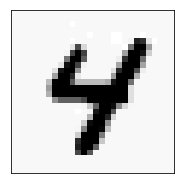

Значение функции активации на 7м нейроне -5.283811092376709


In [39]:
vector2 = torch.tensor(res2.x).float()
imago2 = vector2.view(1,1,28,28)
show_im(imago2, 'BFGS')

print('Значение функции активации на 7м нейроне', modelka(imago2)['y'][0][6].item())

Nelder-Mead


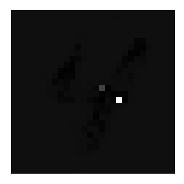

Значение функции активации на 7м нейроне 12.89433765411377


In [40]:
vector3 = torch.tensor(res3.x).float()
imago3 = vector3.view(1,1,28,28)
show_im(imago3, 'Nelder-Mead')

print('Значение функции активации на 7м нейроне', modelka(imago3)['y'][0][6].item())

#### Заключение по обратной задаче

Стремление максимизировать выход нейрона при фиксированных весах по переменному изображению приводит к снижению контрастности основного поля картинки и появлению двух-трех очень контрастных точек.

Идеальной максимизации (до 1, в случае с тангенсом как функции активации) достичь не удалось. Алгоритм Недлера-Мида показал заметно лучшие результаты, чем градиентный BFGS.

### Источники

1. https://neurohive.io/ru/tutorial/cnn-na-pytorch/